In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import plotly
import plotly.express as px
print(plotly.__version__)

import statistics
import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn import preprocessing #библиотеки для нормализации признаков

#библиотеки для обработки текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

5.7.0


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/belov_engineer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Подгрузка и предварительный анализ данных

In [257]:
#подгрузка данных
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [258]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [259]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [260]:
# производим первичный анализ данных
profile = ProfileReport(data.drop('sample',axis=1), title="Booking hotels report")
profile

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<b>Предварительный анализ входных данных:</b>  
* Всего в датасете 515738 отзывов.  
* 10 числовых признаков, 8 категориальных.  
* Пропуски в 6536 строках в признаках lat и lng.   
* Всего 336 дубликатов.   
* Категориальных признаков - 8, числовых - 9.   
* Высокая корреляция между признаком additional_number_of_scoring и рядом других признаков.  
* В данных собраны отзывы о 1493 разных отеля. Есть отели с одинаковыми названиями.   

Признаки

* hotel_address - адрес отеля  
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
    review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля


# 2. Очистка данных

In [262]:
#выявляем отели с одинаковыми называниями и разными адресами
grouped_data = data.groupby(['hotel_name','hotel_address'])['sample'].count().sort_values()
grouped_data.groupby('hotel_name').count().sort_values(ascending=False)

hotel_name
Hotel Regina                                    3
11 Cadogan Gardens                              1
Mercure Paris Gare Montparnasse                 1
Mercure Paris Pigalle Sacre Coeur               1
Mercure Paris Opera Louvre                      1
                                               ..
Ham Yard Hotel                                  1
Hallmark Hotel London Chigwell Prince Regent    1
HCC St Moritz                                   1
HCC Regente                                     1
pentahotel Vienna                               1
Name: sample, Length: 1492, dtype: int64

In [263]:
data[data['hotel_name'] == 'Hotel Regina']['hotel_address'].unique()

array(['Bergara 2 4 Eixample 08002 Barcelona Spain',
       'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria',
       'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy'],
      dtype=object)

Три отеля, расположенные в разных городах, имеют одинаковые названия - "Hotel Regina".  

In [264]:
# изменяем называние отелей, указывая город
data.loc[(data['hotel_address'] == 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria'),'hotel_name'] = 'Hotel Regina in Vienna'
data.loc[(data['hotel_address'] == 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy'),'hotel_name'] = 'Hotel Regina in Milan'

In [265]:
data = data.drop(['lat', 'lng'], axis=1)

# 3. Обработка признаков

## 3.1. Признак hotel_address

In [266]:
#выделяем страну и название города из признака hotel_address
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.endswith('United Kingdom') else x.split()[-2])
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
data.drop('hotel_address',axis=1, inplace=True)

In [267]:
#сводная таблица распределения городов отелей по странам
pd.pivot_table(
    data, 
    values = 'sample', 
    index = ['hotel_country','hotel_city'], 
    aggfunc = 'count'
)

sample
hotel_country  hotel_city        
Austria        Vienna       38939
France         Paris        59928
Italy          Milan        37207
Netherlands    Amsterdam    57214
Spain          Barcelona    60149
United Kingdom London      262301

Одной стране соответствует один город. Соответственно, надо будет закодировать только один из признаков.

In [268]:
# график распределения отелей по странам с учетом того, что по каждому отелю в данных существует некоторое количество отзывов
country_hotels = data.groupby(['hotel_name','hotel_country'], as_index=False)['sample'].count()
country_hotels

hotel_name   hotel_country  sample
0                     11 Cadogan Gardens  United Kingdom     159
1                               1K Hotel          France     148
2     25hours Hotel beim MuseumsQuartier         Austria     689
3                                     41  United Kingdom     103
4     45 Park Lane Dorchester Collection  United Kingdom      28
...                                  ...             ...     ...
1489            citizenM London Bankside  United Kingdom    1517
1490          citizenM London Shoreditch  United Kingdom     838
1491            citizenM Tower of London  United Kingdom    1683
1492              every hotel Piccadilly  United Kingdom     568
1493                   pentahotel Vienna         Austria     129

[1494 rows x 3 columns]

In [269]:
#данные для построения графика о распределении отелей по странам
country_hotels_grouped = country_hotels.groupby('hotel_country',as_index=False)['hotel_name'].count()
country_hotels_grouped.rename(columns={'hotel_name':'hotels_number'},inplace=True)
country_hotels_grouped

hotel_country  hotels_number
0         Austria            158
1          France            458
2           Italy            162
3     Netherlands            105
4           Spain            211
5  United Kingdom            400

In [270]:
fig = px.bar(
    data_frame=country_hotels_grouped, 
    x='hotel_country',
    y='hotels_number', 
    color='hotel_country', 
    text = 'hotels_number', 
    orientation='v', 
    height=500, 
    width=1000, 
    title='Распределение отелей по странам' 
)

fig.show()

<b>Вывод по графику:</b>: Больше всего отелей расположены во Франции и Великобритании.

In [271]:
#кодировка города отеля методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

## 3.2. Признаки страна рецензента и соответствие страны рецензента стране отеля

In [272]:
#количество национальностей рецензентов 
len(data['reviewer_nationality'].unique())

227

In [273]:
#данные для построения графика
bar_data = data.groupby('reviewer_nationality',as_index=False
)[['sample']].count().nlargest(15, columns=['sample'])
bar_data.rename(columns={'sample':'reviewer_number'},inplace=True)
bar_data

reviewer_nationality  reviewer_number
214             United Kingdom            245246
216   United States of America             35437
14                   Australia             21686
98                     Ireland             14827
213       United Arab Emirates             10235
176               Saudi Arabia              8951
144                Netherlands              8772
197                Switzerland              8678
78                     Germany              7941
38                      Canada              7894
72                      France              7296
100                     Israel              6610
101                      Italy              6114
22                     Belgium              6031
206                     Turkey              5444

In [274]:
#строим график распределения рецензентов по странам
fig = px.bar(
    data_frame=bar_data, 
    x="reviewer_nationality", 
    y="reviewer_number", 
    color='reviewer_nationality', 
    text = 'reviewer_number', 
    orientation='v', 
    height=500, 
    width=1000, 
    title='Распределение национальности рецензентов' 
)

#отображаем его
fig.show()

In [275]:
#обработка признака, чтобы убрать пробелы в начале и конце строки
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

In [276]:
#добавляю признак соответствия национальности рецензента стране отеля
data['country_nationality_accordance'] = (data['hotel_country'] == data['reviewer_nationality']).astype(int)

In [277]:
#оставляем 10 наиболее часто встречающихся национальностей, остальные заменяем на Other
top_ten = data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_ten else 'Other')

In [278]:
data['reviewer_nationality'].unique()

array(['United Kingdom', 'Other', 'United States of America',
       'Netherlands', 'Ireland', 'Canada', 'Australia', 'Saudi Arabia',
       'Germany', 'United Arab Emirates', 'Switzerland'], dtype=object)

In [279]:
#кодируем признак национальности рецензента методом двоичного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [280]:
# удаляем преобразованные признаки
data.drop(['hotel_city','hotel_country','reviewer_nationality'],axis=1,inplace=True)

## 3.3. Признак даты отзыва

In [281]:
#месяц, когда был написан отзыв
data['review_date'] = pd.to_datetime(data['review_date'])
data['review_month'] = data['review_date'].dt.month

In [282]:
#дата самого раннего отзыва
data['review_date'].min()

Timestamp('2015-08-04 00:00:00')

In [283]:
#дата последнего отзыва
data['review_date'].max()

Timestamp('2017-08-03 00:00:00')

In [284]:
#кодируем признак в высокий или низкий сезон состоялось посещение отеля
data['high_season'] = data['review_month'].apply(lambda x: 1 if x in [1,5,6,7,8,9] else 0)

## 3.4. Признак срока давности отзыва

In [285]:
#вычисляем признак давности отзыва в месяцах относительно даты последнего отзыва
from datetime import datetime
data['age_of_review'] = data['review_date'] - data['review_date'].min()
data['age_of_review'] = data['age_of_review'].astype(str)
data['age_of_review'] = data['age_of_review'].apply(lambda x: x.split()[0])
data['age_of_review'] = round(data['age_of_review'].astype(int) / 30)

In [286]:
data['age_of_review'].min()

0.0

<AxesSubplot:xlabel='age_of_review', ylabel='Count'>

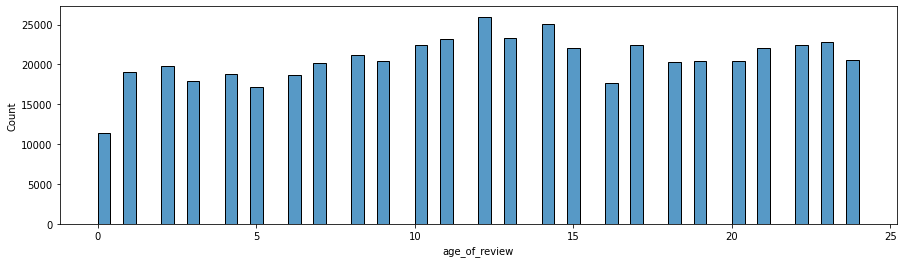

In [287]:
fig = plt.figure(figsize=(15, 4))
sns.histplot(data['age_of_review'], bins=60)

In [288]:
# удаляем признак даты отзыва
data.drop(['review_date','review_month'],axis=1,inplace=True)

In [289]:
#применяем RobustScaler к признаку "возраста" отзыва
r_scaler = preprocessing.RobustScaler()
data['age_of_review'] = r_scaler.fit_transform(data[['age_of_review']])

## 3.5. Признак Отрицательный отзыв

In [290]:
#обрабатываем признак, чтобы убрать пробелы в начале и конце строки
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip())

In [291]:
#проверка часто встречающихся негативных отзывов
data['negative_review'].value_counts().nlargest(10)

No Negative       127890
Nothing            18531
nothing             2508
None                1166
N A                 1060
                     849
Nothing really       570
N a                  520
All good             470
Small room           455
Name: negative_review, dtype: int64

In [292]:
#список ложных отрицательных отзывов 
false_negative = ['We loved everything','not much','Leaving','Was all good','','Coming home','Noting','absolutely nothing','nothing all good','Nothing all great','Nothing It was perfect','Can t think of s thing','Nothing everything was great','No problems at all','All was great','Nothing All good','Not a lot','I liked it all','Cannot think of anything','Nothing negative to say','No comments','Liked it all','Going home','All great','Nothing could have been better','Nothing bad to say','Everything was excellent','No dislikes','Nothing to say','There was nothing we didn t like','All ok','no complaints','No complaints at all','There was nothing to dislike','Nothing I didn t like','As above','nothing really','It was all good','Nothing not to like','Having to leave','Nothing all good','Nothing could have been improved','Can t think of anything really','No Negative','Nothing','nothing','None','N A',' ','Nothing really','N a','All good','No complaints',
                  'Nothing at all','Nothing to dislike','none','Nil','Everything was perfect','Can t think of anything',
                 'n a','Absolutely nothing','Everything was great','Nothing to complain about','NA','NOTHING','I liked everything',
                 'No','Liked everything','Not much','Everything was good','See above','Nothing in particular','Everything was fine','Na',
                 'All was good','Nothing it was perfect','Not applicable','Non','Nothing comes to mind','There was nothing I didn t like',
                 'We liked everything','Nothing everything was perfect','No negatives','Nothing everything was great','Nothing to report',
                 'Not a thing','Loved everything','No thing','all good','There was nothing not to like','No issues','Nothing I can think of',
                 'No bad experience','Nothing to mention','no','No comment','Nothing we didn t like','Nothing to complain','No problems',
                 'I loved everything','nil','nothing at all','nothing bad','Couldn t fault it','Nothing to fault','It was perfect',
                 'Nothing Everything was perfect','There wasn t anything we didn t like','nothing to dislike','Nothing much','non',
                 'That we couldn t stay longer','That we had to leave','No bad experiences','Loved it all','That I couldn t stay longer',
                 'I have no complaints','Nothing it was all good','I can t think of anything','Nothing that I can think of','Nothing of note',
                 'Couldn t fault anything','nothing to complaint about','All was perfect','I had to leave','That I had to leave','Very little','leaving',
                 'everything was perfect','There wasn t anything I didn t like','Having to go home','Nithing','Nothing all was great',
                 'Everything was very good','No complaints whatsoever','Everything was fantastic','Could not fault anything','No complains',
                 'Can t think of any','Nope','Nothing specific','everything was great','no thing','Everything perfect','Can t fault it',
                 'Happy with everything','No one thing','Everything good','Nothing everything was good','There is nothing to dislike',
                 'Nothing I did not like','Nothing to note','Nothings','Nothing all perfect','Nothing bad to report','I','Nothing was bad',
                 'all ok','Nothing to complain about at all','Nothing that I didn t like','Nothinh','We had to leave','Nothing everything was excellent',
                 'There wasn t anything to not to like', 'Can t think of anything I didn t like','I loved it all','Having to come home',
                 'Nothing bad at all','nothing in particular','All very good','nothing comes to mind','There was nothing','Everything was just perfect',
                 'Nothing to say here','Nothing all excellent','I don t know','No faults at all','Wish we could stay longer','Nothing loved it all',
                 'Norhing','Nothing All was great','nothing to say','There wasn t anything','Almost nothing','No things','Nothing that we didn t like',
                 'Nothing to comment','All OK','Not much really','Nothing as such','Nothing to improve','Honestly nothing','Nowt','Nothing to add',
                 'My stay was too short','Nothing it was amazing','I like everything','Nothing so far','nothing to mention','All is good',
                 'Had to leave','nope']

In [293]:
#создаю признак наличия либо отсутствия негативного отзыва
data['negative_review_exists'] = data['negative_review'].apply(lambda x: 0 if x in false_negative else 1 )

## 3.6. Признак Процент истиных негативных отзывов по каждому отелю

In [294]:
#группируем данные
grouped = data.groupby(['hotel_name','total_number_of_reviews'],as_index=False)['negative_review_exists'].sum()
grouped.head()

hotel_name  total_number_of_reviews  \
0                  11 Cadogan Gardens                      393   
1                            1K Hotel                      663   
2  25hours Hotel beim MuseumsQuartier                     4324   
3                                  41                      244   
4  45 Park Lane Dorchester Collection                       68   

   negative_review_exists  
0                      96  
1                     122  
2                     408  
3                      37  
4                       8

In [295]:
#подсчёт процента истиных негативных отзывов по каждому отелю
grouped['%_of_negative_reviews'] = grouped['negative_review_exists'] / grouped['total_number_of_reviews']

<AxesSubplot:>

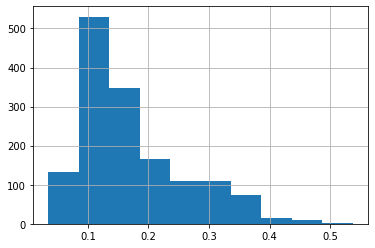

In [296]:
grouped['%_of_negative_reviews'].hist()

In [297]:
grouped['%_of_negative_reviews'].median()

0.1438202969261515

In [298]:
#добавляем признак в данные
grouped.drop(['total_number_of_reviews','negative_review_exists'],axis=1,inplace=True)
data = data.merge(grouped, on='hotel_name',how='left')

<AxesSubplot:>

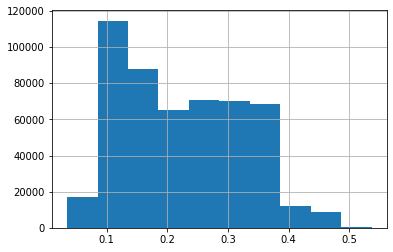

In [299]:
data['%_of_negative_reviews'].hist()

In [300]:
data['%_of_negative_reviews'].median()

0.2176696542893726

## 3.7. Признак Положительный отзыв

In [301]:
#обработка признака, чтобы убрать пробелы в начале и конце строки
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip())

In [302]:
#проверка часто встречающихся позитивных отзывов
data['positive_review'].value_counts().nlargest(10)

No Positive       35946
Location          10137
Everything         2897
location           1736
Nothing            1468
Great location     1419
The location       1341
Good location      1203
Breakfast           664
Friendly staff      603
Name: positive_review, dtype: int64

In [303]:
#список ложных положительных отзывов
false_positive = ['No Positive','Nothing','nothing','Not much','']

In [304]:
#создание признака наличия либо отсутствия истиного положительного отзыва
data['positive_review_exists'] = data['positive_review'].apply(lambda x: 0 if x in false_positive else 1 )

## 3.8. Признак Процент истиных положительных отзывов

In [305]:
grouped = data.groupby(['hotel_name','total_number_of_reviews'],as_index=False)['positive_review_exists'].sum()
grouped.head(2)

hotel_name  total_number_of_reviews  positive_review_exists
0  11 Cadogan Gardens                      393                     149
1            1K Hotel                      663                     134

In [306]:
grouped['%_of_positive_reviews'] = grouped['positive_review_exists'] / grouped['total_number_of_reviews']

<AxesSubplot:>

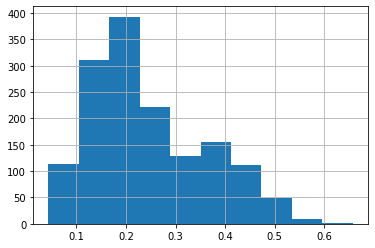

In [307]:
grouped['%_of_positive_reviews'].hist()

In [308]:
#добавляем новый признак в датасет
grouped.drop(['total_number_of_reviews','positive_review_exists'],axis=1,inplace=True)
data = data.merge(grouped, on='hotel_name',how='left')

<AxesSubplot:>

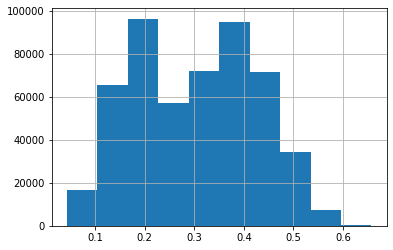

In [309]:
data['%_of_positive_reviews'].hist()

In [310]:
data.drop(['total_number_of_reviews'],axis=1,inplace=True)

In [311]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  object 
 

## 3.9. Признаки процентного содержания негативных и позитивных слов в отзыве

In [312]:
#поскольку количество слов в негативных и позитивных отзывах, указанное в признаках не соответствует действительности, пересчитаю эти значения
data['review_total_negative_word_counts'] = data['negative_review'].apply(lambda x: len(x.split()))
data['review_total_positive_word_counts'] = data['positive_review'].apply(lambda x: len(x.split()))

In [313]:
#заменяю значение количества слов в ложных негативных отзывах на 0
data.loc[(data['negative_review_exists'] == 0), 'review_total_negative_word_counts'] = 0
data.loc[(data['positive_review_exists'] == 0), 'review_total_positive_word_counts'] = 0

In [314]:
data[['negative_review','review_total_negative_word_counts','positive_review','review_total_positive_word_counts']].head(6)

negative_review  \
0  Would have appreciated a shop in the hotel tha...   
1        No tissue paper box was present at the room   
2                                            Pillows   
3                                        No Negative   
4                                        No Negative   
5                          They don t have free wifi   

   review_total_negative_word_counts  \
0                                 50   
1                                  9   
2                                  1   
3                                  0   
4                                  0   
5                                  6   

                                     positive_review  \
0  Hotel was great clean friendly staff free brea...   
1                                        No Positive   
2                         Nice welcoming and service   
3  Everything including the nice upgrade The Hote...   
4                     Lovely hotel v welcoming staff   
5  The location is perfect if you don t have a lo...   

   review_total_positive_word_counts  
0                                 60  
1                                  0  
2                                  4  
3                                 26  
4                                  5  
5                                 24

In [315]:
data['review_total_negative_word_counts'].max()

406

In [316]:
#процент содержания негативных и позитивных слов в отзыве
data['%_of_negative_words'] = data['review_total_negative_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
data['%_of_positive_words'] = data['review_total_positive_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])

In [317]:
#проверка признаков на наличие пропусков
cols_null_percent = data[['%_of_negative_words','%_of_positive_words']].isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

%_of_negative_words    0.093458
%_of_positive_words    0.093458
dtype: float64

In [318]:
#заменяю пропуски на 0
data['%_of_negative_words'] = data['%_of_negative_words'].fillna(0)
data['%_of_positive_words'] = data['%_of_positive_words'].fillna(0)

In [319]:
#проверяю признаки на наличие np.inf значений
np.all(np.isfinite(data[['%_of_negative_words','%_of_positive_words']]))

True

array([[<AxesSubplot:title={'center':'%_of_negative_words'}>,
        <AxesSubplot:title={'center':'%_of_positive_words'}>]],
      dtype=object)

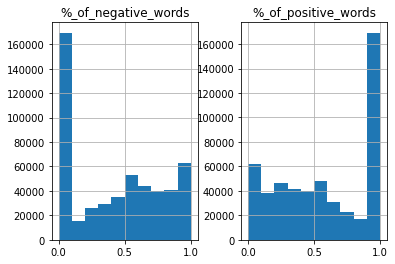

In [320]:
data[['%_of_negative_words','%_of_positive_words']].hist()

In [321]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  object 
 

## 3.10. Признак разности количества слов в положительном и отрицательном отзывах

In [322]:
data['dif_of_positive_negative'] = (data['review_total_positive_word_counts'] + 1) / (data['review_total_negative_word_counts'] + 1) / 100

<AxesSubplot:>

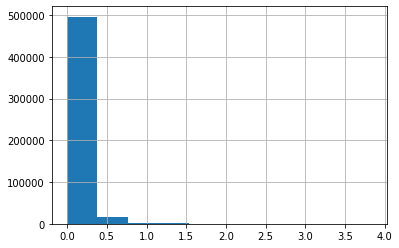

In [323]:
data['dif_of_positive_negative'].hist()

## 3.11. Признаки удовлетворенности рецензента отелем

In [324]:
# пакет символьной и статистической обработки текста для анализа отзывов
sent_analyzer = SentimentIntensityAnalyzer()

# анализ отзывов
data['negative_sent_review'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['positive_sent_review'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# записываю результаты в основной датафрейм в виде отдельных признаков
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['negative_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['positive_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.head(3)

additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   

                                   hotel_name  \
0                              Hotel Da Vinci   
1                           Urban Lodge Hotel   
2  Alexandra Barcelona A DoubleTree by Hilton   

                                     negative_review  \
0  Would have appreciated a shop in the hotel tha...   
1        No tissue paper box was present at the room   
2                                            Pillows   

   review_total_negative_word_counts  \
0                                 50   
1                                  9   
2                                  1   

                                     positive_review  \
0  Hotel was great clean friendly staff free brea...   
1                                        No Positive   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 60   
1                                  0   
2                                  4   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   

                                                tags days_since_review  ...  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days  ...   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day  ...   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day  ...   

                                negative_sent_review  \
0  {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...   
1  {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

                                positive_sent_review  n_neg  n_neu  n_pos  \
0  {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...  0.129  0.747  0.125   
1  {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...  0.216  0.784  0.000   
2  {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...  0.000  1.000  0.000   

   n_compound  p_neg  p_neu  p_pos  p_compound  
0     -0.0554  0.000  0.671  0.329      0.9615  
1     -0.2960  0.379  0.000  0.621      0.3400  
2      0.0000  0.000  0.260  0.740      0.6908  

[3 rows x 42 columns]

In [325]:
data.drop(['negative_review','positive_review','negative_sent_review','positive_sent_review'],axis=1,inplace=True)

## 3.12. Признак tags

In [327]:
data['tags'].unique()

array(["[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",
       "[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",
       "[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
       ...,
       "[' Business trip ', ' Family with older children ', ' Single Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Solo traveler ', ' Luxury Room 1 Queensize Bed Twin bedded Room On Request ', ' Stayed 6 nights ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Couple ', ' Bunk Bed Room ', ' Stayed 4 nights ']"],
      dtype=object)

In [328]:
#избавляюсь от прямых скобок
data['tags'] = data['tags'].apply(lambda x: x.strip('[]'))

In [329]:
#избавляюсь от кавычек и пробелов
data['tags'] = data['tags'].apply(lambda x: [w.strip(" '") for w in x.split(',')])

In [330]:
display(data['tags'])

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515733    [Leisure trip, Group, Club Double or Twin Room...
515734    [Leisure trip, Couple, Standard Double Room, S...
515735    [Business trip, Solo traveler, Single Room, St...
515736    [Leisure trip, Solo traveler, Deluxe Double Ro...
515737    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515738, dtype: object

In [331]:
#считаю количество одинаковых тегов
tags_dict = {}
def fill_tags_dict(x):
    for elem in x:
        if elem in tags_dict:
            tags_dict[elem] = tags_dict[elem] + 1
        else:
            tags_dict[elem] = 1
    return x
data['tags'].apply(fill_tags_dict) 

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515733    [Leisure trip, Group, Club Double or Twin Room...
515734    [Leisure trip, Couple, Standard Double Room, S...
515735    [Business trip, Solo traveler, Single Room, St...
515736    [Leisure trip, Solo traveler, Deluxe Double Ro...
515737    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515738, dtype: object

In [332]:
len(tags_dict)

2428

In [333]:
#создаю DataFrame, отсортированный по частоте втречаемости тегов
tags_count = pd.DataFrame(tags_dict,index=['count']).transpose()
tags_sorted = tags_count.sort_values(by='count', ascending=False).head(30)

In [334]:
display(tags_sorted)

count
Leisure trip                    417778
Submitted from a mobile device  307640
Couple                          252294
Stayed 1 night                  193645
Stayed 2 nights                 133937
Solo traveler                   108545
Stayed 3 nights                  95821
Business trip                    82939
Group                            65392
Family with young children       61015
Stayed 4 nights                  47817
Double Room                      35207
Standard Double Room             32248
Superior Double Room             31393
Family with older children       26349
Deluxe Double Room               24823
Double or Twin Room              22393
Stayed 5 nights                  20845
Standard Double or Twin Room     17483
Classic Double Room              16989
Superior Double or Twin Room     13570
2 rooms                          12393
Stayed 6 nights                   9776
Standard Twin Room                9745
Single Room                       9670
Twin Room                         8321
Stayed 7 nights                   7399
Executive Double Room             6425
Classic Double or Twin Room       6107
Superior Twin Room                6064

In [335]:
#создаю список наиболее часто встречающихся тегов
tags_30 = list(tags_sorted.index)

In [336]:
display(tags_30)

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room',
 'Superior Double or Twin Room',
 '2 rooms',
 'Stayed 6 nights',
 'Standard Twin Room',
 'Single Room',
 'Twin Room',
 'Stayed 7 nights',
 'Executive Double Room',
 'Classic Double or Twin Room',
 'Superior Twin Room']

In [337]:
#кодирую наиболее часто встречающиеся теги
for tag in tags_30:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

In [338]:
#предположу, что продолжительность проживания в отеле в течении одного или двух дней может повлиять на характер оценки отеля
#удаляю ненужные признаки
data.drop(['Stayed 3 nights','Stayed 4 nights','Stayed 5 nights','Stayed 6 nights','Stayed 7 nights'], axis=1, inplace=True)

In [339]:
#объединяю теги для номеров одинаковой категории
#standard double or twin room
data['standard_double_twin_room'] = ((data['Double Room']==1)|(data['Standard Double Room']==1)|(data['Double or Twin Room']==1)|
                        (data['Standard Double or Twin Room']==1)|(data['Classic Double Room']==1)|(data['2 rooms']==1)|
                        (data['Standard Twin Room']==1)|(data['Twin Room']==1)|(data['Classic Double or Twin Room']==1)).astype(int)
data.drop(['Double Room','Standard Double Room','Double or Twin Room','Standard Double or Twin Room','Classic Double Room','2 rooms',
          'Standard Twin Room','Twin Room','Classic Double or Twin Room'],axis=1,inplace=True)
#superior double or twin room
data['superior_double_twin_room'] = ((data['Superior Double Room']==1)|(data['Superior Double or Twin Room'])|
                        (data['Superior Twin Room'])|(data['Deluxe Double Room'])).astype(int)
data.drop(['Superior Double Room','Superior Double or Twin Room','Superior Twin Room','Deluxe Double Room'],axis=1,inplace=True)

In [340]:
data.drop(['tags'], axis=1, inplace=True)

In [341]:
data_fixed = data.copy()

In [342]:
data = data_fixed

# 4. Подготовка данных к обучению модели

In [343]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

<AxesSubplot:>

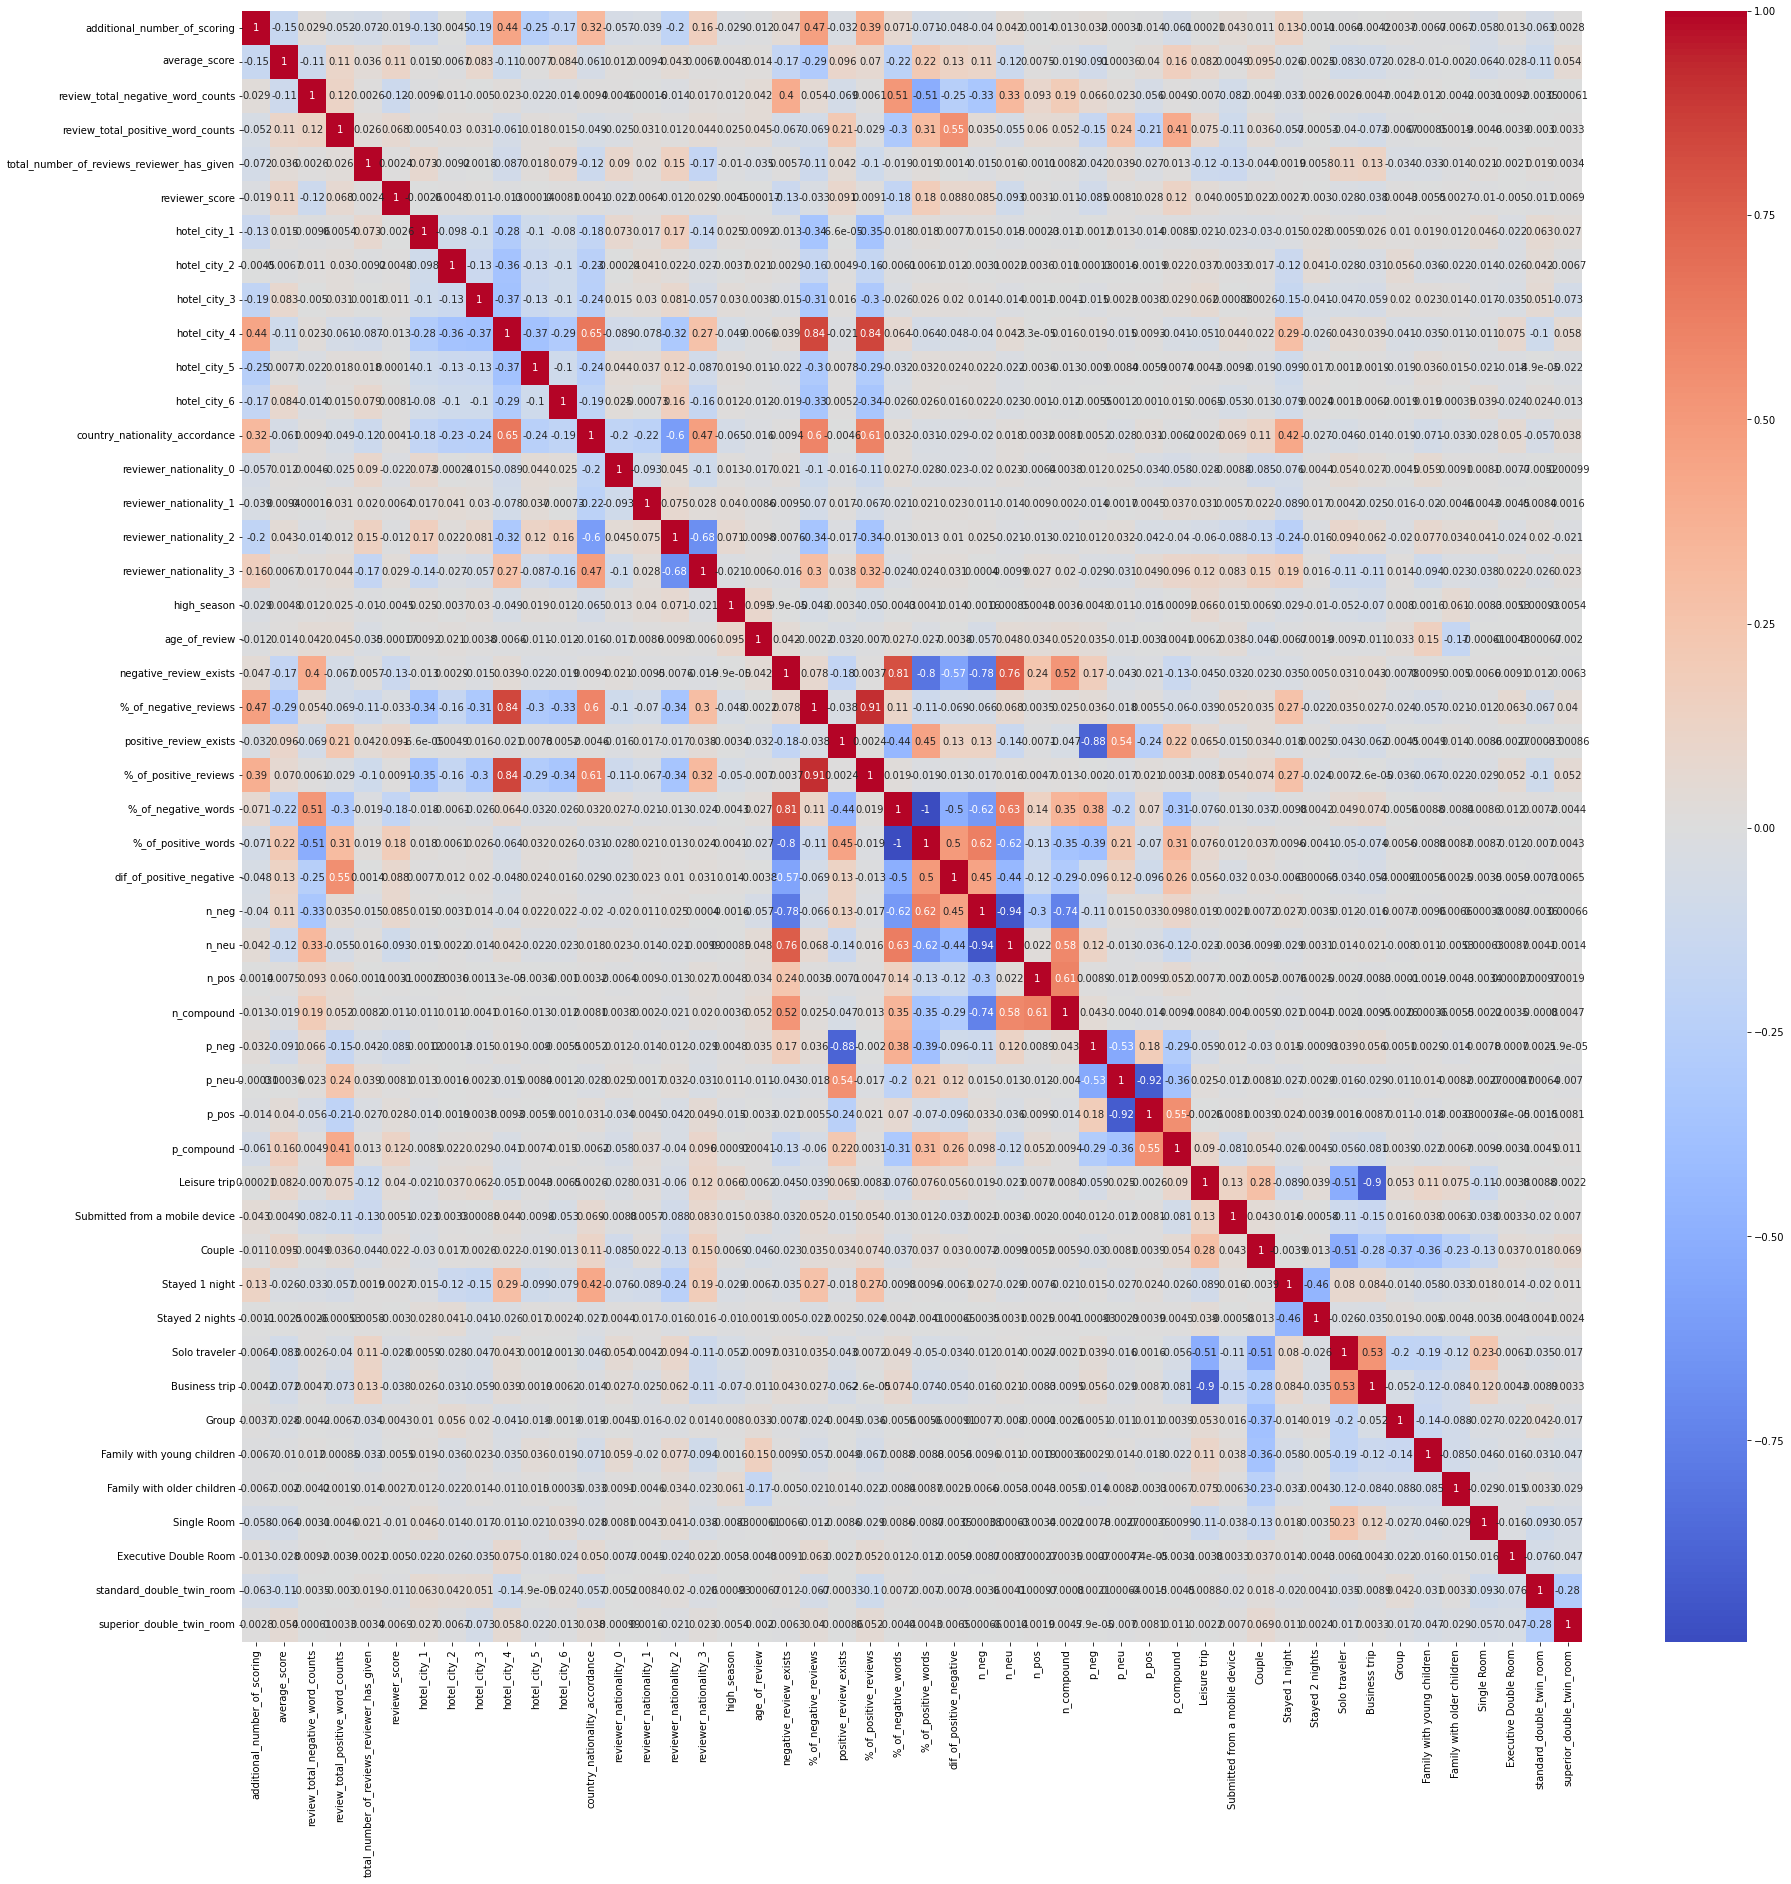

In [344]:
#проверка признака на мультиколлинеарность
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True,cmap='coolwarm')

In [345]:
#удаляем сильно коррелирующие признаки
data.drop(['Business trip','%_of_negative_reviews','positive_review_exists','negative_review_exists','n_compound','p_pos','p_neu','n_compound','review_total_negative_word_counts','%_of_positive_words','hotel_city_4'],axis=1,inplace=True)

In [346]:
#удаляем неинформативные признаки
data.drop(['additional_number_of_scoring','total_number_of_reviews_reviewer_has_given'],axis=1,inplace=True)

In [347]:
#стандартизация признаков
col_name= data[['average_score',
                'review_total_positive_word_counts'
               ]]
scaler = preprocessing.StandardScaler()
data_scalar = scaler.fit_transform(col_name)
data_scalar = pd.DataFrame(data_scalar,columns=col_name.columns)

Проверяю признаки на значимость

In [348]:
# непрерывные признаки
num_cols = ['average_score','review_total_positive_word_counts',
            'age_of_review','%_of_positive_reviews','%_of_negative_words',
            'dif_of_positive_negative','n_neg','n_neu','n_pos','p_neg','p_compound']

# категориальные признаки
cat_cols = ['average_score','country_nationality_accordance', 'high_season', 'Leisure trip','Submitted from a mobile device',
            'Couple', 'Stayed 1 night', 'Stayed 2 nights','Group','Family with young children',
            'Family with older children','Single Room','Executive Double Room','standard_double_twin_room',
            'superior_double_twin_room','hotel_city_1','hotel_city_2','hotel_city_3',
        'reviewer_nationality_0','reviewer_nationality_1','reviewer_nationality_2','reviewer_nationality_3']
           

In [349]:
data[num_cols].describe()

average_score  review_total_positive_word_counts  age_of_review  \
count  515738.000000                      515738.000000  515738.000000   
mean        8.397487                          16.322875      -0.043862   
std         0.548048                          21.564775       0.633720   
min         5.200000                           0.000000      -1.181818   
25%         8.100000                           4.000000      -0.545455   
50%         8.400000                          10.000000       0.000000   
75%         8.800000                          21.000000       0.454545   
max         9.800000                         393.000000       1.000000   

       %_of_positive_reviews  %_of_negative_words  dif_of_positive_negative  \
count          515738.000000        515738.000000             515738.000000   
mean                0.303036             0.423438                  0.069777   
std                 0.121283             0.358407                  0.150275   
min                 0.043478             0.000000                  0.000025   
25%                 0.194365             0.000000                  0.004000   
50%                 0.309934             0.444444                  0.012273   
75%                 0.404878             0.736842                  0.070000   
max                 0.657343             1.000000                  3.830000   

               n_neg          n_neu          n_pos          p_neg  \
count  515738.000000  515738.000000  515738.000000  515738.000000   
mean        0.321205       0.618542       0.054882       0.034813   
std         0.410677       0.392945       0.118784       0.103267   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.104000       0.781000       0.000000       0.000000   
75%         1.000000       1.000000       0.061000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          p_compound  
count  515738.000000  
mean        0.593776  
std         0.342077  
min        -0.983200  
25%         0.361200  
50%         0.708900  
75%         0.883400  
max         0.999300

<AxesSubplot:>

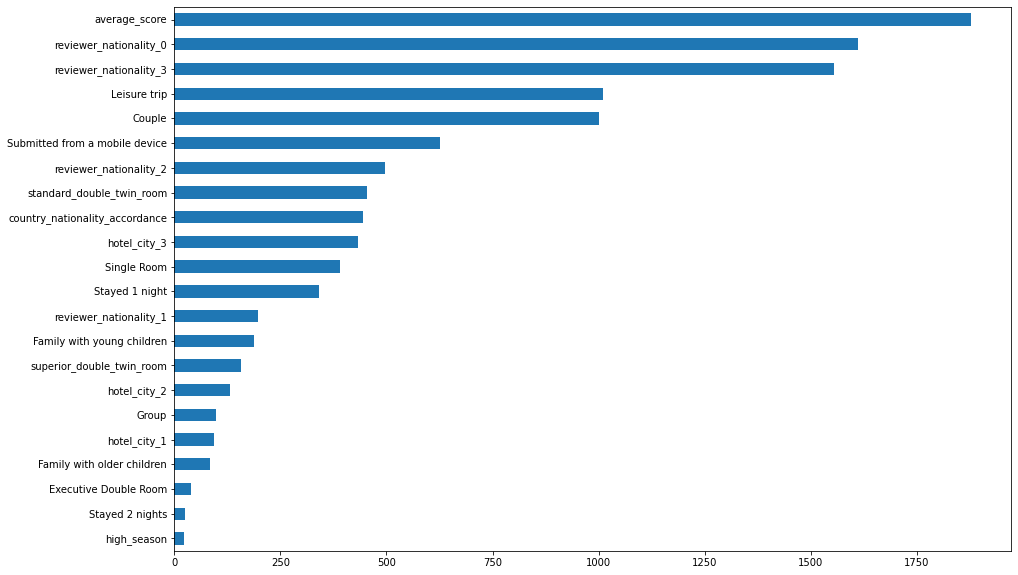

In [350]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

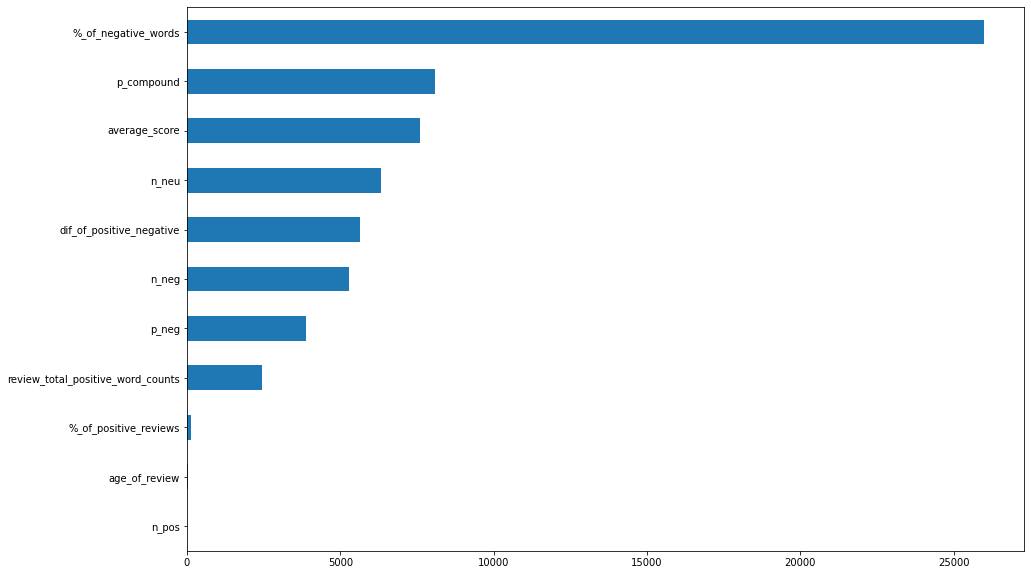

In [351]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

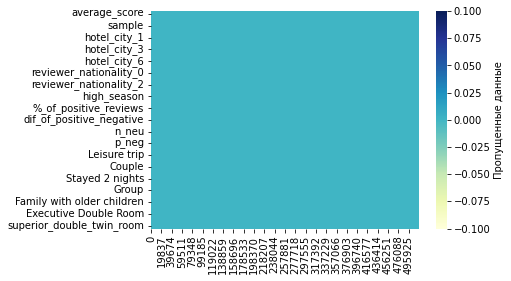

In [352]:
# Визуализация пропусков
plt.figure(figsize=(6,4))
sns.heatmap(data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Пропущенные данные'})
plt.show()

# 5. Обучение модели и анализ результатов

In [353]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [354]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [355]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 36), (386803, 36), (386803, 35), (309442, 35), (77361, 35))

In [356]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [357]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [358]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [359]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.870874895111416


<AxesSubplot:>

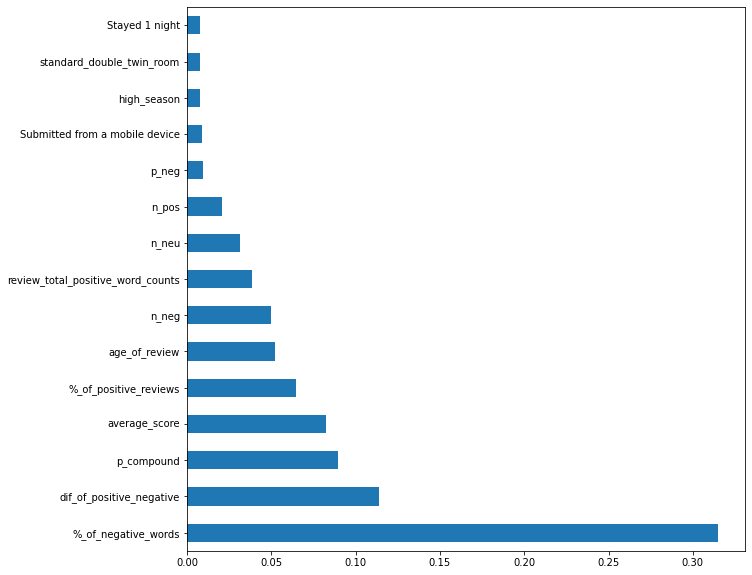

In [360]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [361]:
test_data.sample(10)

average_score  review_total_positive_word_counts  reviewer_score  \
22137             7.4                                 10             0.0   
29877             8.8                                 92             0.0   
61538             8.3                                 12             0.0   
59605             8.4                                  8             0.0   
64047             8.2                                  2             0.0   
118780            8.3                                 26             0.0   
4599              8.0                                  5             0.0   
113659            8.4                                 35             0.0   
89140             7.3                                  4             0.0   
127183            8.8                                  5             0.0   

        hotel_city_1  hotel_city_2  hotel_city_3  hotel_city_5  hotel_city_6  \
22137              1             0             0             0             0   
29877              0             0             1             0             0   
61538              0             0             0             0             0   
59605              0             1             0             0             0   
64047              0             0             0             1             0   
118780             0             0             0             0             0   
4599               0             0             1             0             0   
113659             1             0             0             0             0   
89140              0             1             0             0             0   
127183             0             0             0             0             1   

        country_nationality_accordance  reviewer_nationality_0  ...  \
22137                                0                       0  ...   
29877                                0                       0  ...   
61538                                1                       0  ...   
59605                                1                       0  ...   
64047                                0                       0  ...   
118780                               1                       0  ...   
4599                                 0                       0  ...   
113659                               0                       0  ...   
89140                                0                       0  ...   
127183                               0                       0  ...   

        Stayed 1 night  Stayed 2 nights  Solo traveler  Group  \
22137                0                1              1      0   
29877                0                0              0      1   
61538                0                1              0      0   
59605                1                0              0      0   
64047                1                0              1      0   
118780               0                1              0      0   
4599                 0                0              0      0   
113659               0                0              1      0   
89140                0                1              0      0   
127183               0                0              0      0   

        Family with young children  Family with older children  Single Room  \
22137                            0                           0            1   
29877                            0                           0            0   
61538                            1                           0            0   
59605                            0                           0            0   
64047                            0                           0            0   
118780                           1                           0            0   
4599                             0                           0            0   
113659                           0                           0            0   
89140                            0                           0            0   
12

In [362]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [363]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [364]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [365]:
predict_submission

array([8.641, 7.507, 8.2  , ..., 7.996, 9.623, 7.653])

In [366]:
list(sample_submission)

['reviewer_score', 'id']

In [367]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.641  488440
1           7.507  274649
2           8.200  374688
3           9.649  404352
4           9.617  451596
5           8.799  302161
6           7.555  317079
7           7.160   13963
8           7.941  159785
9           7.021  195089